In [8]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [1]:
!conda info


     active environment : env1
    active env location : C:\Users\Vibhu007\Anaconda3\envs\env1
            shell level : 1
       user config file : C:\Users\Vibhu007\.condarc
 populated config files : C:\Users\Vibhu007\.condarc
          conda version : 4.10.3
    conda-build version : 3.17.8
         python version : 3.7.3.final.0
       virtual packages : __cuda=9.1=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\Vibhu007\Anaconda3  (writable)
      conda av data dir : C:\Users\Vibhu007\Anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.ana

In [2]:
import sys
print(sys.executable)

C:\Users\Vibhu007\Anaconda3\envs\env1\python.exe


In [3]:
import tensorflow
print(tensorflow.__version__)

1.15.2


Using TensorFlow backend.


In [4]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("content"))

['font', 'images', 'model_data', 'readme', 'yad2k', 'yolo_utils.py']


In [5]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
import PIL
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
import keras 
print(keras.__version__)

2.3.1


In [7]:
import colorsys
import imghdr
import os
import random
from keras import backend as K

import numpy as np
from PIL import Image, ImageDraw, ImageFont

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors
def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def scale_boxes(boxes, image_shape):
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='content/font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        top, left, bottom, right = box
        # print('here', (left,top), (right,bottom))
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

def yolo_head(feats, anchors, num_classes):
    
    num_anchors = len(anchors)
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))


    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_class_probs = K.softmax(feats[..., 5:])

    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_confidence, box_xy, box_wh, box_class_probs
def yolo_boxes_to_corners(box_xy, box_wh):
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])
        

In [8]:
yolo_model = load_model("content/model_data/yolo.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




C:\Users\Vibhu007\Anaconda3\envs\env1\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
yolo_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [10]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
   
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = box_class_scores>threshold

    scores = tf.boolean_mask(box_class_scores,filtering_mask,name="scores")
    boxes = tf.boolean_mask(boxes, filtering_mask, name='boxes')
    classes = tf.boolean_mask(box_classes,filtering_mask, name="boxes")
    return scores, boxes, classes

In [11]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):

    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)

    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)
    return scores, boxes, classes

In [12]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
     
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    

    
    return scores, boxes, classes

In [13]:
sess = K.get_session()


In [14]:
class_names = read_classes("content/model_data/coco_classes.txt")
anchors = read_anchors("content/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)  

In [15]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [16]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [17]:
def predict(sess, image_file):

    image, image_data = preprocess_image("content/images/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)

    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    plt.imshow(image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


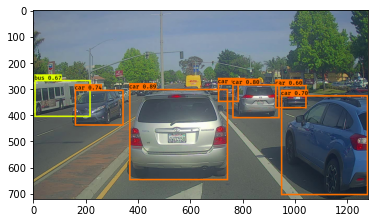

In [18]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

  Model has predicted cars and buses from the image. 

Found 7 boxes for test4.jpg
person 0.61 (103, 306) (148, 401)
car 0.62 (346, 288) (425, 337)
car 0.71 (458, 311) (534, 383)
car 0.71 (631, 352) (733, 446)
car 0.74 (882, 381) (1077, 505)
car 0.83 (794, 455) (1031, 622)
car 0.85 (540, 450) (737, 657)


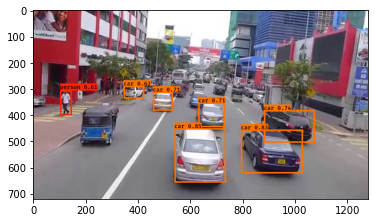

In [27]:
out_scores, out_boxes, out_classes = predict(sess, "test4.jpg")

In [43]:
image = Image.open('content/images/shot283.jpg')
image = image.resize((1280, 720) , Image.BICUBIC)
image.save('content/images/test69.jpg')

Found 3 boxes for test69.jpg
here (1107.0342, 133.21268) (1200.4866, 177.14246)
car 0.53 (1107, 133) (1200, 177)
here (949.9125, 140.1784) (1116.7202, 219.48984)
car 0.56 (950, 140) (1117, 219)
here (266.10123, 318.16214) (611.37866, 477.67453)
car 0.89 (266, 318) (611, 478)


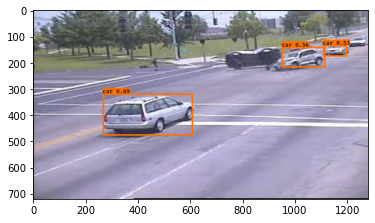

In [27]:
out_scores, out_boxes, out_classes = predict(sess, "test69.jpg")

In [25]:
print(out_scores)
print(out_boxes)
print(out_classes)

[0.88978916 0.56136614 0.53035194]
[[ 318.16214  266.10123  477.67453  611.37866]
 [ 140.1784   949.9125   219.48984 1116.7202 ]
 [ 133.21268 1107.0342   177.14246 1200.4866 ]]
[2 2 2]


## Try for overlapping boxes

In [19]:
frame_path = '../../major project/dataset/frames/'

l = os.listdir(frame_path)
print(len(l))

12812


In [20]:
for frame in l:
    print(frame)
    break

vid142-shot1.jpg


In [21]:
def myPredict(sess, image_file):

    image, image_data = preprocess_image(frame_path + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

#     print('Found {} boxes for {}'.format(len(out_boxes), image_file))
#     colors = generate_colors(class_names)

#     draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
#     plt.imshow(image)
    
    return out_scores, out_boxes, out_classes

### Test non_accident_frames list

In [27]:
accident_frames = [187, 192, 193, 194, 195, 196, 245, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 366]
non_accident_frames = giveNoAccidentFrameList(accident_frames)
print(len(non_accident_frames))
print(non_accident_frames)

17
[186, 191, 190, 197, 198, 244, 319, 318, 317, 316, 315, 331, 332, 333, 334, 335, 365]


## Try for videos

In [22]:
from IoU import *

# checks if frames contains a possible overlap/accident
def check_frame(frame):
    out_scores, out_boxes, out_classes = myPredict(sess, frame)

    for i in range(0,len(out_scores)):
        if out_classes[i] != 2:
            continue
        
        x1 = np.floor(out_boxes[i][1])
        y1 = np.floor(out_boxes[i][0])
        x2 = np.floor(out_boxes[i][3])
        y2 = np.floor(out_boxes[i][2])
        box1 = {'x1':x1, 'x2':x2, 'y1':y1, 'y2':y2}
        
        for j in range(i+1,len(out_scores)):
            if out_classes[j] != 2:
                continue
            x3 = np.floor(out_boxes[j][1])
            y3 = np.floor(out_boxes[j][0])
            x4 = np.floor(out_boxes[j][3])
            y4 = np.floor(out_boxes[j][2])
            box2 = {'x1':x3, 'x2':x4, 'y1':y3, 'y2':y4}
            
            iou = get_iou(box1, box2)
            
            if iou >= 0.2:
                # accident possible
                print('Overlap', frame)
                return True
            
    return False

## Detect key frames

In [23]:
from frameUtility import *

frame_path = '../../major project/dataset/frames/'
l = os.listdir(frame_path) 

global i
i = 0
while i < len(l):
    #print(i)
    frame = l[i]
    vid_num = int(frame[3:frame.find('-')])
    
    accident_frames = []
    j = i
    while True:
        curr_frame = l[j]
        curr_vid_num = int(curr_frame[3:curr_frame.find('-')])
        curr_shot_num = int(curr_frame[curr_frame.find('t')+1 : curr_frame.find('.')])
        
        if check_frame(curr_frame):
            accident_frames.append(curr_shot_num) # this is an accident key frame
        j += 1
        
        if j % 50 == 0:
            print('completed',j,'frames till vid', vid_num)
        
        if j == len(l) or curr_vid_num != vid_num:
            break
    
    non_accident_frames = giveNoAccidentFrameList(accident_frames)
    copy_frames(vid_num, accident_frames, non_accident_frames)
    
    print(accident_frames)
    print(non_accident_frames)
    print('copied key frames of vid', vid_num)
    #print(j)
    print()
    
    i = j

completed 50 frames till vid 142
completed 100 frames till vid 142
Overlap vid142-shot1120.jpg
Overlap vid142-shot1121.jpg
Overlap vid142-shot1124.jpg
completed 150 frames till vid 142
completed 200 frames till vid 142
completed 250 frames till vid 142
completed 300 frames till vid 142
completed 350 frames till vid 142
completed 400 frames till vid 142
completed 450 frames till vid 142
Overlap vid142-shot1446.jpg
Overlap vid142-shot1447.jpg
Overlap vid142-shot1448.jpg
completed 500 frames till vid 142
Overlap vid142-shot1458.jpg
completed 550 frames till vid 142
completed 600 frames till vid 142
completed 650 frames till vid 142
completed 700 frames till vid 142
completed 750 frames till vid 142
completed 800 frames till vid 142
Overlap vid142-shot1734.jpg
Overlap vid142-shot1735.jpg
Overlap vid142-shot1736.jpg
completed 850 frames till vid 142
completed 900 frames till vid 142
Overlap vid142-shot1815.jpg
completed 950 frames till vid 142
Overlap vid142-shot1869.jpg
completed 1000 fram

completed 5800 frames till vid 144
completed 5850 frames till vid 144
Overlap vid144-shot695.jpg
Overlap vid144-shot708.jpg
Overlap vid144-shot709.jpg
Overlap vid144-shot710.jpg
Overlap vid144-shot711.jpg
Overlap vid144-shot712.jpg
completed 5900 frames till vid 144
completed 5950 frames till vid 144
Overlap vid144-shot797.jpg
Overlap vid144-shot798.jpg
Overlap vid144-shot799.jpg
Overlap vid144-shot800.jpg
Overlap vid144-shot802.jpg
completed 6000 frames till vid 144
Overlap vid144-shot858.jpg
Overlap vid144-shot860.jpg
Overlap vid144-shot861.jpg
Overlap vid144-shot862.jpg
completed 6050 frames till vid 144
Overlap vid144-shot863.jpg
Overlap vid144-shot864.jpg
Overlap vid144-shot865.jpg
Overlap vid144-shot866.jpg
Frame index out of bound
[545, 546, 58, 695, 708, 709, 710, 711, 712, 797, 798, 799, 800, 802, 858, 860, 861, 862, 863, 864, 865, 866]
[544, 547, 57, 694, 707, 706, 713, 714, 796, 795, 801, 801, 857, 859, 867, 868, 869]
copied key frames of vid 144

Overlap vid145-shot1012.jpg

completed 12200 frames till vid 151
completed 12250 frames till vid 151
Overlap vid151-shot352.jpg
Overlap vid151-shot353.jpg
Overlap vid151-shot354.jpg
Overlap vid151-shot379.jpg
Overlap vid151-shot380.jpg
Overlap vid151-shot381.jpg
Overlap vid151-shot395.jpg
Overlap vid151-shot396.jpg
completed 12300 frames till vid 151
Overlap vid151-shot397.jpg
completed 12350 frames till vid 151
completed 12400 frames till vid 151
completed 12450 frames till vid 151
completed 12500 frames till vid 151
completed 12550 frames till vid 151
Overlap vid151-shot646.jpg
completed 12600 frames till vid 151
completed 12650 frames till vid 151
completed 12700 frames till vid 151
Overlap vid151-shot784.jpg
Overlap vid151-shot785.jpg
Overlap vid151-shot786.jpg
Overlap vid151-shot787.jpg
Overlap vid151-shot788.jpg
Overlap vid151-shot789.jpg
Overlap vid151-shot790.jpg
Overlap vid151-shot795.jpg
Overlap vid151-shot800.jpg
completed 12750 frames till vid 151
Overlap vid151-shot803.jpg
Overlap vid151-shot804.jpg
c